# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

keywords are unexpanded, not using


In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,0.185996,False,0.811559
1,-1.829677,False,-3.766985
2,-1.129297,True,3.252654
3,1.226271,True,5.942464
4,-0.267470,True,2.050480
...,...,...,...
995,-2.068876,False,-4.872676
996,-0.154224,False,-1.859878
997,-0.682200,True,3.794221
998,-0.349099,True,2.837868


<AxesSubplot:xlabel='v0'>

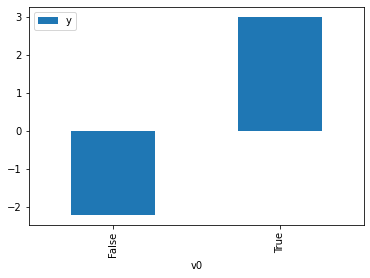

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<AxesSubplot:xlabel='v0'>

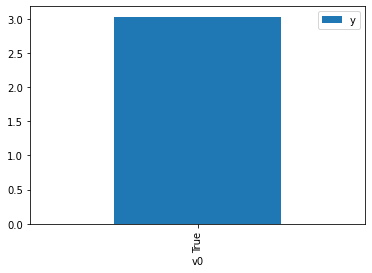

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,-0.450128,False,-1.123750,0.639576,1.563535
1,-0.450128,False,-1.123750,0.639576,1.563535
2,-2.200439,False,-4.535381,0.923815,1.082468
3,-1.659571,False,-3.981770,0.870059,1.149348
4,-0.625355,False,-1.465888,0.682638,1.464905
...,...,...,...,...,...
995,-1.330808,False,-2.219560,0.823538,1.214274
996,-1.410193,False,-4.302867,0.835849,1.196388
997,0.173279,False,0.113379,0.472287,2.117357
998,-0.839927,False,-2.947091,0.731357,1.367321


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,-2.190194,True,-0.664264,0.076981,12.990260
1,-2.204565,True,-0.855231,0.075867,13.180951
2,1.002572,True,6.914696,0.735268,1.360047
3,-1.146044,True,2.830075,0.207900,4.810011
4,-1.777388,True,-0.984186,0.116003,8.620477
...,...,...,...,...,...
995,-0.182658,True,5.417711,0.430491,2.322928
996,-1.189833,True,2.850478,0.200093,4.997673
997,-0.480086,True,3.367830,0.352876,2.833854
998,0.453010,True,6.140423,0.603030,1.658292


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.934
Model:                            OLS   Adj. R-squared (uncentered):              0.934
Method:                 Least Squares   F-statistic:                              7110.
Date:                Mon, 08 Aug 2022   Prob (F-statistic):                        0.00
Time:                        04:36:34   Log-Likelihood:                         -1440.8
No. Observations:                1000   AIC:                                      2886.
Df Residuals:                     998   BIC:                                      2895.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             2.2633      0.024     93.451      0.000       2.216       2.311
x2             5.0639      0.060     83.916      0.000       4.945       5.182
==============================================================================
Omnibus:                        2.765   Durbin-Watson:                   1.950
Prob(Omnibus):                  0.251   Jarque-Bera (JB):                2.831
Skew:                           0.124   Prob(JB):                        0.243
Kurtosis:                       2.917   Cond. No.                         2.51
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""